# AI-Enhanced 60/40 Portfolio - Data Exploration

This notebook explores the market data and economic indicators used in the AI-driven portfolio strategy.

## Objectives:
1. Load and visualize asset prices
2. Analyze economic indicators (VIX, Yield Spread, Interest Rates)
3. Explore correlations and relationships
4. Understand market regimes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
warnings.filterwarnings('ignore')
from data_acquisition import DataAcquisition
from feature_engineering import FeatureEngineer
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Configuration and Data

In [2]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"  Start Date: {config['data']['start_date']}")
print(f"  End Date: {config['data']['end_date']}")
print(f"  Rebalance Frequency: {config['data']['rebalance_frequency']}")

Configuration loaded:
  Start Date: 2017-01-01
  End Date: 2024-12-31
  Rebalance Frequency: M


In [3]:
# Initialize data acquisition
data_acq = DataAcquisition(config)

# Fetch all data
prices, returns, indicators = data_acq.get_full_dataset()

print("\nData loaded successfully!")
print(f"Prices shape: {prices.shape}")
print(f"Returns shape: {returns.shape}")
print(f"Indicators shape: {indicators.shape}")

Fetching asset prices...
Fetched prices for 4 assets from 2017-01-01 00:00:00 to 2024-12-30 00:00:00
Fetching VIX data...
Fetching yield spread data...
Fetching interest rate data...

Indicators summary:
             VIX  Yield_Spread  Interest_Rate
count  2922.0000     2922.0000      2922.0000
mean     18.6570        0.4484         2.1637
std       7.6876        0.9770         1.9075
min       9.1400       -1.7040         0.0400
25%      13.2225       -0.2868         0.2700
50%      16.8800        0.5650         1.6900
75%      21.8800        1.2457         4.3300
max      82.6900        2.3080         5.3300

Data loaded successfully!
Prices shape: (96, 4)
Returns shape: (96, 4)
Indicators shape: (96, 3)


## 2. Asset Price Analysis

In [4]:
# Display first and last few rows
print("First 5 rows of prices:")
display(prices.head())

print("\nLast 5 rows of prices:")
display(prices.tail())

# Summary statistics
print("\nPrice summary statistics:")
display(prices.describe())

First 5 rows of prices:


Ticker,BTC-USD,GLD,SPY,TLT
2017-01-31,970.4030,115.55,196.9815,93.8779
2017-02-28,1179.9700,119.23,204.7212,95.3654
2017-03-31,1071.7900,118.72,204.9771,94.7407
2017-04-30,1347.8900,120.77,207.0117,96.2312
2017-05-31,2286.4099,120.62,209.9332,98.0479



Last 5 rows of prices:


Ticker,BTC-USD,GLD,SPY,TLT
2024-08-31,58969.8984,231.29,553.5706,90.8042
2024-09-30,63329.5000,243.06,565.1982,92.6198
2024-10-31,70215.1875,253.51,560.1546,87.5675
2024-11-30,96449.0547,245.59,593.5585,89.3077
2024-12-31,92643.2109,240.63,581.3926,84.0589



Price summary statistics:


Ticker,BTC-USD,GLD,SPY,TLT
count,96.0000,96.0000,96.0000,96.0000
mean,25448.3597,159.7630,345.2204,105.7549
std,22568.1979,34.1755,104.6406,17.5287
min,970.4030,112.7600,196.9815,76.1116
25%,7550.7649,124.7100,250.0044,92.6494
50%,18300.1777,164.5150,343.6135,99.0760
75%,39268.8926,178.6375,413.6332,120.2097
max,96449.0547,253.5100,593.5585,145.2890


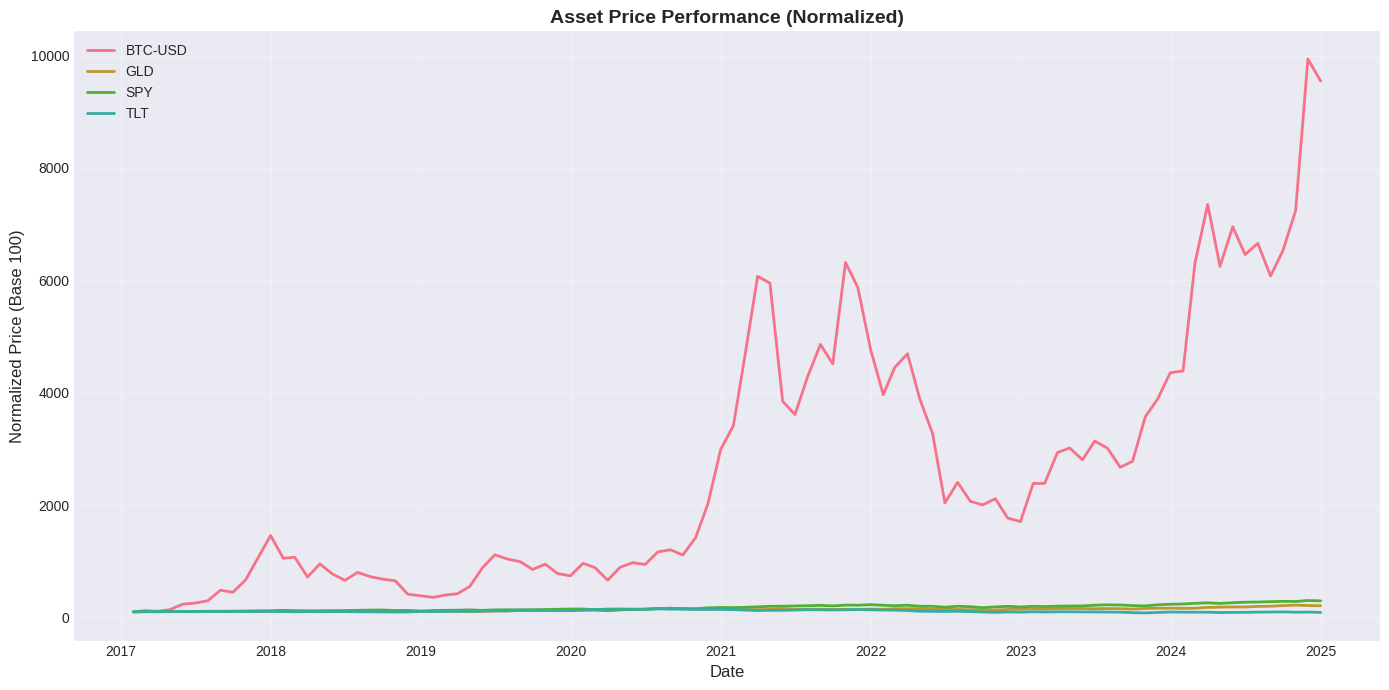


Cumulative returns:
  BTC-USD: +9446.88%
  GLD: +108.25%
  SPY: +195.15%
  TLT: -10.46%


In [5]:
# Plot normalized prices
fig, ax = plt.subplots(figsize=(14, 7))

normalized_prices = prices / prices.iloc[0] * 100

for col in normalized_prices.columns:
    ax.plot(normalized_prices.index, normalized_prices[col], label=col, linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Price (Base 100)', fontsize=12)
ax.set_title('Asset Price Performance (Normalized)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCumulative returns:")
cumulative_returns = (prices.iloc[-1] / prices.iloc[0] - 1) * 100
for asset, ret in cumulative_returns.items():
    print(f"  {asset}: {ret:+.2f}%")

## 3. Returns Analysis

In [6]:
# Returns statistics
print("Returns summary statistics:")
display(returns.describe())

# Annualized metrics
print("\nAnnualized metrics (assuming monthly data):")
annual_return = returns.mean() * 12
annual_vol = returns.std() * np.sqrt(12)
sharpe_ratio = annual_return / annual_vol

metrics_df = pd.DataFrame({
    'Annual Return': annual_return,
    'Annual Volatility': annual_vol,
    'Sharpe Ratio': sharpe_ratio
})
display(metrics_df)

Returns summary statistics:


Ticker,BTC-USD,GLD,SPY,TLT
count,96.0000,96.0000,96.0000,96.0000
mean,0.0033,-0.0003,-0.0005,0.0012
std,0.0337,0.0075,0.0084,0.0066
min,-0.0955,-0.0318,-0.0196,-0.0212
25%,-0.0160,-0.0032,-0.0036,-0.0003
50%,-0.0005,0.0000,0.0000,0.0000
75%,0.0178,0.0028,0.0027,0.0047
max,0.1454,0.0181,0.0315,0.0219



Annualized metrics (assuming monthly data):


,Annual Return,Annual Volatility,Sharpe Ratio
Ticker,,,
BTC-USD,0.0400,0.1169,0.3418
GLD,-0.0030,0.0261,-0.1156
SPY,-0.0060,0.0289,-0.2088
TLT,0.0145,0.0228,0.6351


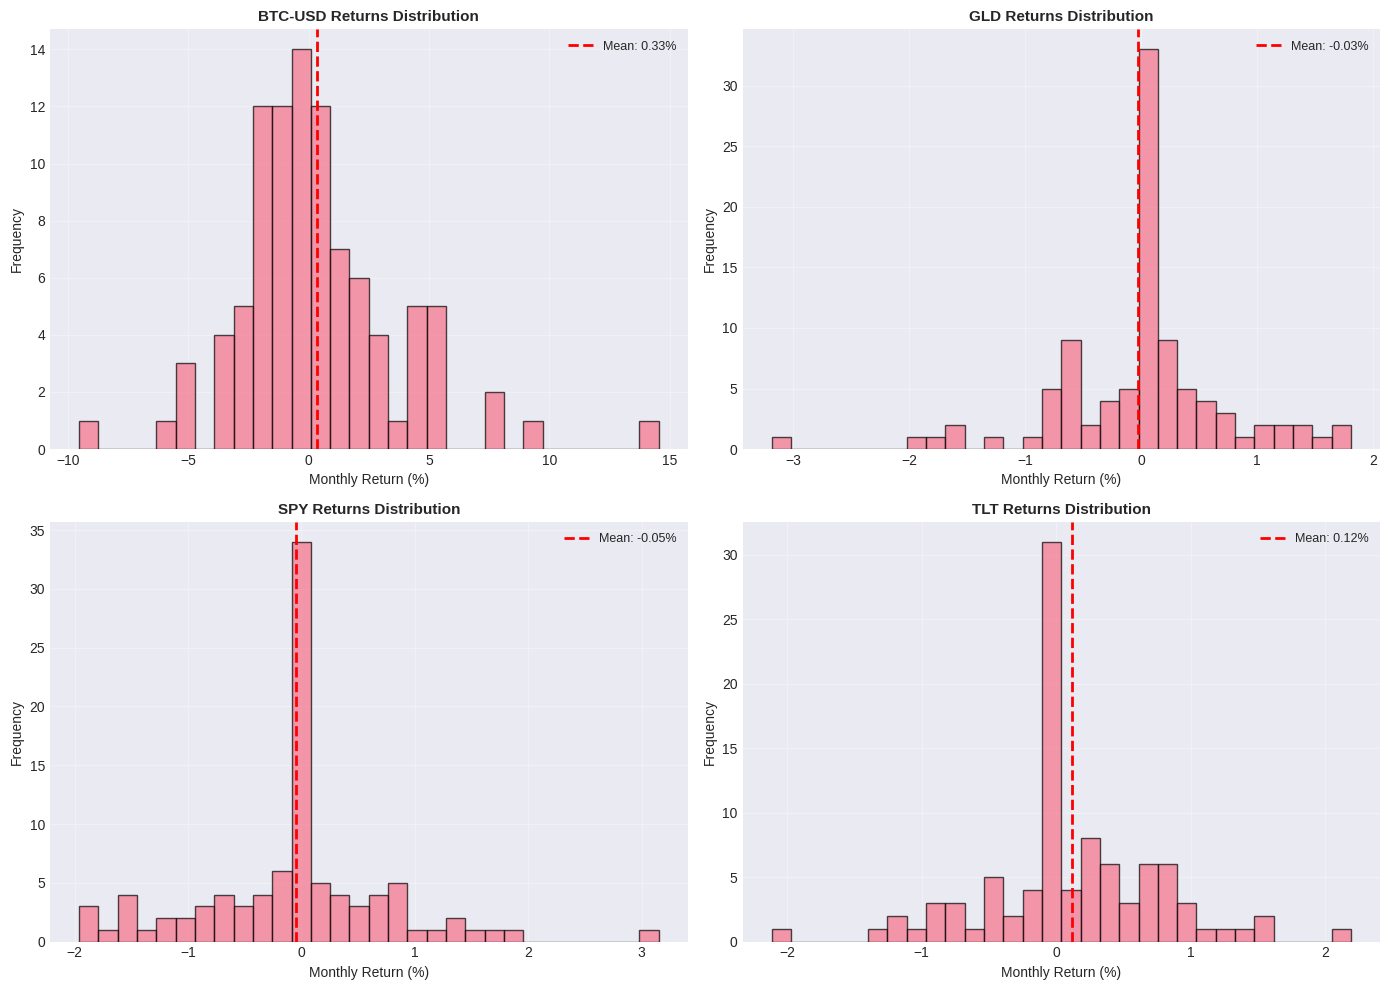

In [7]:
# Plot returns distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(returns.columns):
    if i < len(axes):
        axes[i].hist(returns[col] * 100, bins=30, edgecolor='black', alpha=0.7)
        axes[i].axvline(returns[col].mean() * 100, color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {returns[col].mean()*100:.2f}%')
        axes[i].set_xlabel('Monthly Return (%)', fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].set_title(f'{col} Returns Distribution', fontsize=11, fontweight='bold')
        axes[i].legend(fontsize=9)
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

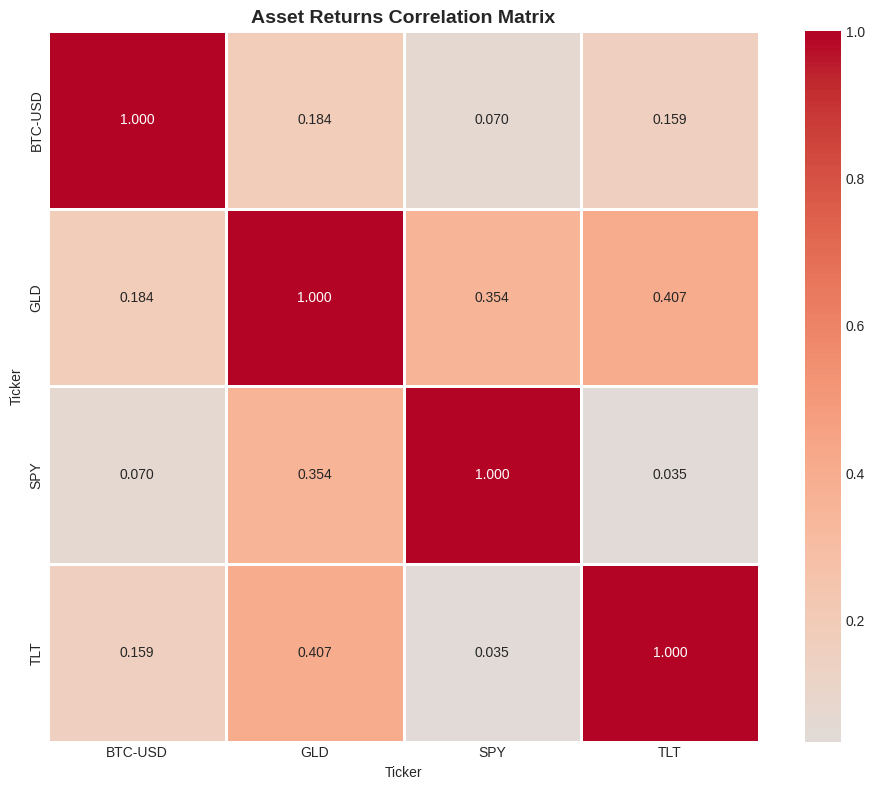


Key correlations:
Ticker   BTC-USD     GLD     SPY     TLT
Ticker                                  
BTC-USD   1.0000  0.1837  0.0701  0.1591
GLD       0.1837  1.0000  0.3539  0.4067
SPY       0.0701  0.3539  1.0000  0.0353
TLT       0.1591  0.4067  0.0353  1.0000


In [8]:
# Returns correlation matrix
corr_matrix = returns.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=ax)
ax.set_title('Asset Returns Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey correlations:")
print(corr_matrix)

## 4. Economic Indicators Analysis

In [9]:
# Display indicators
print("Economic indicators:")
display(indicators.head(10))

print("\nIndicators summary statistics:")
display(indicators.describe())

Economic indicators:


,VIX,Yield_Spread,Interest_Rate
2017-01-31,11.99,1.951,0.56
2017-02-28,12.92,1.835,0.57
2017-03-31,12.37,1.658,0.82
2017-04-30,10.82,1.502,0.83
2017-05-31,10.41,1.246,0.83
2017-06-30,11.18,1.309,1.06
2017-07-31,10.26,1.239,1.07
2017-08-31,10.59,1.143,1.07
2017-09-30,9.51,1.298,1.06
2017-10-31,10.18,1.253,1.07



Indicators summary statistics:


,VIX,Yield_Spread,Interest_Rate
count,96.0000,96.0000,96.0000
mean,18.9709,0.4343,2.1695
std,7.5614,0.9715,1.9268
min,9.5100,-1.6110,0.0500
25%,13.4825,-0.2415,0.2725
50%,16.7450,0.5620,1.6800
75%,21.9400,1.2507,4.3300
max,53.5400,2.0790,5.3300


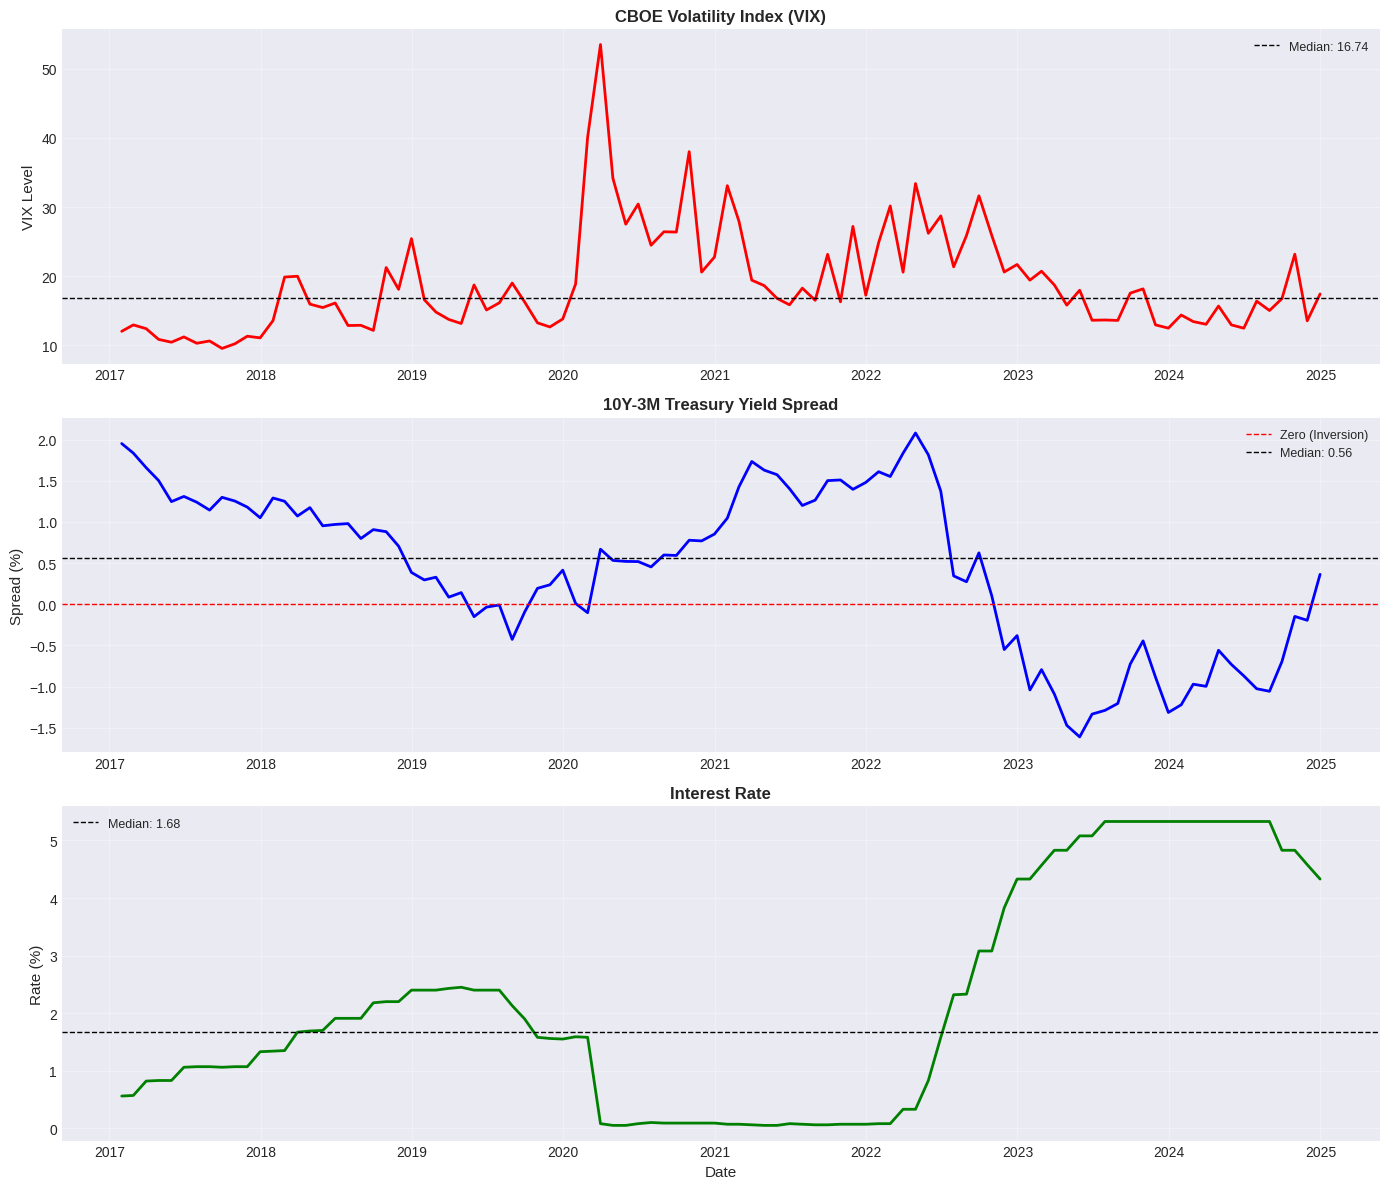

In [10]:
# Plot all indicators
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# VIX
axes[0].plot(indicators.index, indicators['VIX'], color='red', linewidth=2)
axes[0].set_ylabel('VIX Level', fontsize=11)
axes[0].set_title('CBOE Volatility Index (VIX)', fontsize=12, fontweight='bold')
axes[0].axhline(y=indicators['VIX'].median(), color='black', linestyle='--', 
               linewidth=1, label=f'Median: {indicators["VIX"].median():.2f}')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Yield Spread
axes[1].plot(indicators.index, indicators['Yield_Spread'], color='blue', linewidth=2)
axes[1].set_ylabel('Spread (%)', fontsize=11)
axes[1].set_title('10Y-3M Treasury Yield Spread', fontsize=12, fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero (Inversion)')
axes[1].axhline(y=indicators['Yield_Spread'].median(), color='black', linestyle='--', 
               linewidth=1, label=f'Median: {indicators["Yield_Spread"].median():.2f}')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# Interest Rate
axes[2].plot(indicators.index, indicators['Interest_Rate'], color='green', linewidth=2)
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Rate (%)', fontsize=11)
axes[2].set_title('Interest Rate', fontsize=12, fontweight='bold')
axes[2].axhline(y=indicators['Interest_Rate'].median(), color='black', linestyle='--', 
               linewidth=1, label=f'Median: {indicators["Interest_Rate"].median():.2f}')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Correlation between indicators and asset returns:


,VIX,Yield_Spread,Interest_Rate
BTC-USD,-0.1030,0.2407,-0.2388
GLD,-0.2829,0.0707,-0.0777
SPY,-0.1857,-0.1573,0.1055
TLT,-0.1940,-0.1571,0.1364


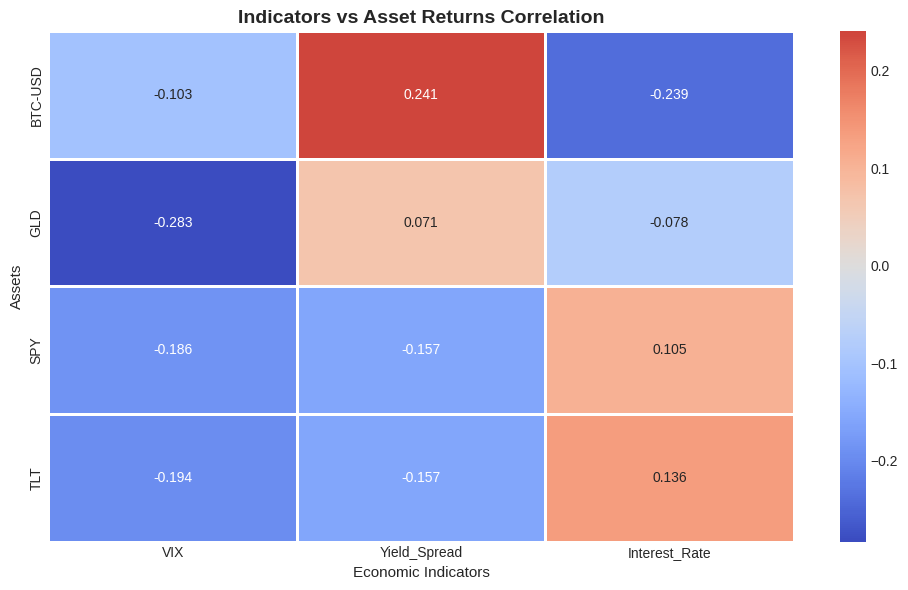

In [11]:
# Indicators correlation with asset returns
indicator_return_corr = pd.DataFrame()

for indicator in indicators.columns:
    corrs = {}
    for asset in returns.columns:
        # Calculate correlation
        aligned_data = pd.concat([indicators[indicator], returns[asset]], axis=1).dropna()
        corrs[asset] = aligned_data.corr().iloc[0, 1]
    indicator_return_corr[indicator] = pd.Series(corrs)

print("Correlation between indicators and asset returns:")
display(indicator_return_corr)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(indicator_return_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, linewidths=1, ax=ax)
ax.set_title('Indicators vs Asset Returns Correlation', fontsize=14, fontweight='bold')
ax.set_xlabel('Economic Indicators', fontsize=11)
ax.set_ylabel('Assets', fontsize=11)
plt.tight_layout()
plt.show()

## 5. Market Regime Analysis

In [12]:
# Define market regimes
regimes = pd.DataFrame(index=indicators.index)

# Volatility regimes
vix_median = indicators['VIX'].median()
regimes['High_Volatility'] = indicators['VIX'] > vix_median

# Yield curve regimes
regimes['Inverted_Curve'] = indicators['Yield_Spread'] < 0
regimes['Flat_Curve'] = indicators['Yield_Spread'].abs() < 0.5
regimes['Steep_Curve'] = indicators['Yield_Spread'] > 1.5

# Interest rate regimes
rate_median = indicators['Interest_Rate'].median()
regimes['High_Rate'] = indicators['Interest_Rate'] > rate_median

print("Market regime frequencies:")
for col in regimes.columns:
    freq = regimes[col].sum() / len(regimes)
    print(f"  {col}: {freq:.1%} of the time")

Market regime frequencies:
  High_Volatility: 50.0% of the time
  Inverted_Curve: 32.3% of the time
  Flat_Curve: 25.0% of the time
  Steep_Curve: 14.6% of the time
  High_Rate: 50.0% of the time


In [13]:
# Analyze returns by regime
print("\nAverage returns by market regime:\n")

for regime_col in regimes.columns:
    print(f"{regime_col}:")
    
    # Split returns by regime
    regime_true = returns[regimes[regime_col]]
    regime_false = returns[~regimes[regime_col]]
    
    print(f"  When {regime_col} = True:")
    avg_returns_true = regime_true.mean() * 12 * 100
    for asset, ret in avg_returns_true.items():
        print(f"    {asset}: {ret:+.2f}% annualized")
    
    print(f"  When {regime_col} = False:")
    avg_returns_false = regime_false.mean() * 12 * 100
    for asset, ret in avg_returns_false.items():
        print(f"    {asset}: {ret:+.2f}% annualized")
    
    print()


Average returns by market regime:

High_Volatility:
  When High_Volatility = True:
    BTC-USD: +2.97% annualized
    GLD: -0.57% annualized
    SPY: -1.74% annualized
    TLT: +1.04% annualized
  When High_Volatility = False:
    BTC-USD: +5.02% annualized
    GLD: -0.04% annualized
    SPY: +0.53% annualized
    TLT: +1.85% annualized

Inverted_Curve:
  When Inverted_Curve = True:
    BTC-USD: -5.61% annualized
    GLD: -1.03% annualized
    SPY: +1.35% annualized
    TLT: +3.52% annualized
  When Inverted_Curve = False:
    BTC-USD: +8.57% annualized
    GLD: +0.04% annualized
    SPY: -1.54% annualized
    TLT: +0.46% annualized

Flat_Curve:
  When Flat_Curve = True:
    BTC-USD: -5.41% annualized
    GLD: -1.45% annualized
    SPY: -2.68% annualized
    TLT: +1.87% annualized
  When Flat_Curve = False:
    BTC-USD: +7.13% annualized
    GLD: +0.08% annualized
    SPY: +0.09% annualized
    TLT: +1.31% annualized

Steep_Curve:
  When Steep_Curve = True:
    BTC-USD: +33.79% annual